# <center>Формирование модели монетизации игрового приложения</center>

#### Описание проекта:
Основной датасет содержит данные о событиях, совершенных в мобильной игре "~~название засекреченно~~". В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

#### Задача:
* На основе данных понять, какую модель монетизации стоит выбрать для игрового приложения

#### Содержание:<a id="content"></a>
1. [Обзор данных](#info)
2. [Исследовательский анализ](#research_analysis)
3. [Анализ данных](#data_analysis)
4. [Анализ маркетинга](#marketing)
5. [Анализ взаимодействия с целевым событием](#target_analysis)
6. [Проверка гипотез](#stat_test)
5. [Выводы и рекомендации](#summary)

#### Импорты:

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go

## Загрузка и обзор данных:<a id="info"></a>
[вернуться к содержанию](#content)

#### Датасеты:

In [2]:
ad_costs = pd.read_csv('ad_costs.csv')
events = pd.read_csv('events.csv')
user_source = pd.read_csv('user_source.csv')

#### Датасет _"events"_ содержит данные о событии и совершении его пользователем 

In [3]:
display(events.head())
display(events.shape)
display(events.info())

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


(135640, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

Датасет *events.csv* содержит колонки:

- `event_datetime` - время совершения события
- `event` - название события
- `building_type` - тип объекта строительства
- `user_id` - идентификатор пользователя
- `project_type` - тип реализованного проекта

Расшифровки событий:

- Колонка `event`:
    - `building` - Постройка объекта
    - `finished_stage_1` - Окончание первого уровня
    - `project` - Реализация проекта
- Колонка `building_type` - тип объекта для постройки:
    - `assembly_shop` - Сборочный цех
    - `spaceport` - Космопорт
    - `research_center` - Исследовательский центр
___

#### Датасет _"ad_costs"_ содержит данные расходах на рекламу

In [4]:
display(ad_costs.head())
display(ad_costs.shape)
display(ad_costs.info())

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


(28, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

Датасет *ad_costs.csv* содержит колонки:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов
___

#### Датасет _"user_source"_ содержит данные о источнике, с которого пришел пользователь 

In [5]:
display(user_source.head())
display(user_source.shape)
display(user_source.info())

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


(13576, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

#### Вывод:

* В таблице `events` требуется:
    * Преобразовать столбец `event_datetime` в формат datetime
    * Заменить пропуски в столбце `project_type`
    * Выделить день из даты
* В таблице `ad_costs` требуется:
    * Преобразовать столбце `day` в формат datetime

#### Предобработка данных:

Преобразуем столбцы к формату datetime:

In [6]:
events['event_datetime'] = pd.to_datetime(events['event_datetime'], format='%Y-%m-%d %H:%M:%S')
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')

Выделим дату из стобца `event_datetime`:

In [7]:
events['event_date'] = events['event_datetime'].dt.date.astype('datetime64')

Заменим пропуски в столбце `project_type`, чтобы в дальнейшем можно было считать эти значения:

In [8]:
events['project_type'] = events['project_type'].fillna('none')

Проверим таблицы на наличие дубликатов:

In [9]:
print('Дубликатов в таблице "events":', events.duplicated().sum())
print('Дубликатов в таблице "ad_costs":', ad_costs.duplicated().sum())
print('Дубликатов в таблице "user_source":', user_source.duplicated().sum())


Дубликатов в таблице "events": 1
Дубликатов в таблице "ad_costs": 0
Дубликатов в таблице "user_source": 0


Один дубликат в таблице "events", посмотрим, почему так произошло:

In [10]:
events[events.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type,event_date
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,none,2020-05-10
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,none,2020-05-10


Строка продублировалась полностью, похоже на тех. ошибку. Один дубликат можно удалить.

In [11]:
events = events.drop_duplicates()

## Исследовательский анализ (EDA)<a id="research_analysis"></a>
[вернуться к содержанию](#content)

In [12]:
print('Кол-во пользователей:', events['user_id'].count())
print('Кол-во уникальных пользователей:', events['user_id'].nunique())

Кол-во пользователей: 135639
Кол-во уникальных пользователей: 13576


___

Посмотрим на распределение времени в таблице `events`:

In [13]:
display(events['event_datetime'].min())
display(events['event_datetime'].max())

Timestamp('2020-05-04 00:00:01')

Timestamp('2020-06-05 12:32:49')

Данные в таблице `events` представлены с 4 мая 2020 года по 5 июня 2020 года.

Посмотрим на распределение времени в таблице `ad_costs`:

In [14]:
display(ad_costs['day'].min())
display(ad_costs['day'].max())

Timestamp('2020-05-03 00:00:00')

Timestamp('2020-05-09 00:00:00')

Данные в таблице `ad_costs` представлены с 3 мая 2020 года по 9 мая 2020 года, реклама закупалась всего 6 дней. Судя по данным, реклама покупалась за день до предоставленных в таблице `events` логов, из-за чего потерян один день.
___

,index,event_cnt,%_of_total
0,building,127956,0.94
1,finished_stage_1,5817,0.04
2,project,1866,0.01


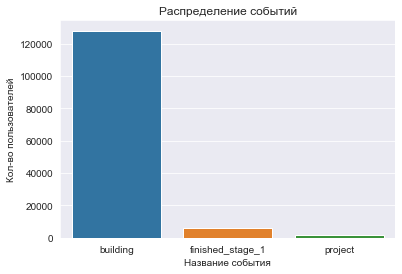

In [15]:
eventtype = events['event'].value_counts().reset_index().rename({'event':'event_cnt'}, axis=1)
eventtype['%_of_total'] = (eventtype['event_cnt'] / eventtype['event_cnt'].sum()).round(2)
display(eventtype)

sns.set_style("darkgrid")
sns.countplot(events['event'])
plt.title('Распределение событий')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Название события');

Почти 130т. событий именуются как `building`, т.е. пользователь находятся в процессе строительства какой-либо постройки. Около 6т. пользователей из выборки закончили первый уровень, 2т. сделали это посредством реализации проекта.  

___

,index,building_type_cnt,%_of_total
0,spaceport,59325,0.46
1,assembly_shop,54494,0.43
2,research_center,14137,0.11


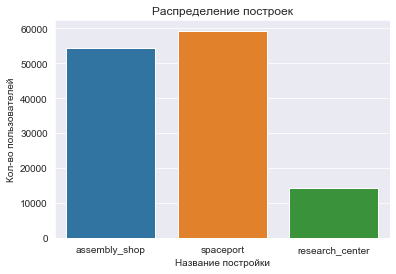

In [16]:
buildingtype = events['building_type'].value_counts().reset_index().rename({'building_type':'building_type_cnt'}, axis=1)
buildingtype['%_of_total'] = (buildingtype['building_type_cnt'] / buildingtype['building_type_cnt'].sum()).round(2)
display(buildingtype)

sns.countplot(events['building_type'])
plt.title('Распределение построек')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Название постройки');

Практически поровну распределились постройки `assembly_shop (60т.)` и `spaceport (54т.)`, `research_center` построили только 14т. пользователей.

## Анализ данных:<a id="data_analysis"></a>
[вернуться к содержанию](#content)

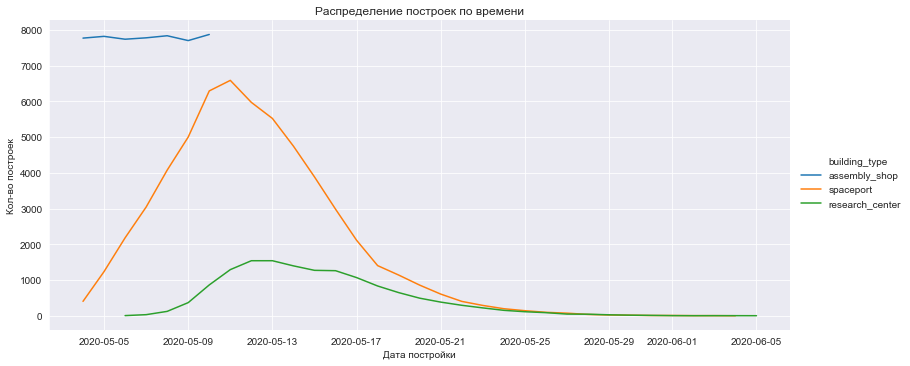

In [17]:
buildingtype = events.groupby(['event_date', 'building_type'])['user_id'].count().reset_index()
sns.relplot(data=buildingtype, x='event_date', y='user_id', hue='building_type', kind='line', aspect=18/8)
plt.title('Распределение построек по времени')
plt.ylabel('Кол-во построек')
plt.xlabel('Дата постройки');

Из данного графика можно увидеть, что первая постройка пользователей - `assembly_shop`, которая, скорее всего строится игроками первой и недолго, т.к. сразу же можно увидеть параллелно восходящий тренд к строительству объекта `spaceport`, на пике которого линия постройки `assembly_shop` обрывается. Это может говорить о том, что данную постройку больше нельзя построить после строительства `spaceport`.  `research_center` первые активные игроки построили уже спустя пару дней, основная масса сделала это спустя +- неделю. Также можно наблюдать спад активности строительства. Это может говорить о том, что либо пользователь остановился в прогрессе и ушел, либо перешел на следующий уровень.
___

Посморим, сколько уникальных пользователей приходит в день:

In [18]:
dau = events.merge(user_source, how='left', on='user_id')
dau_groupby = dau.groupby(['event_date', 'source'])['user_id'].nunique().reset_index()

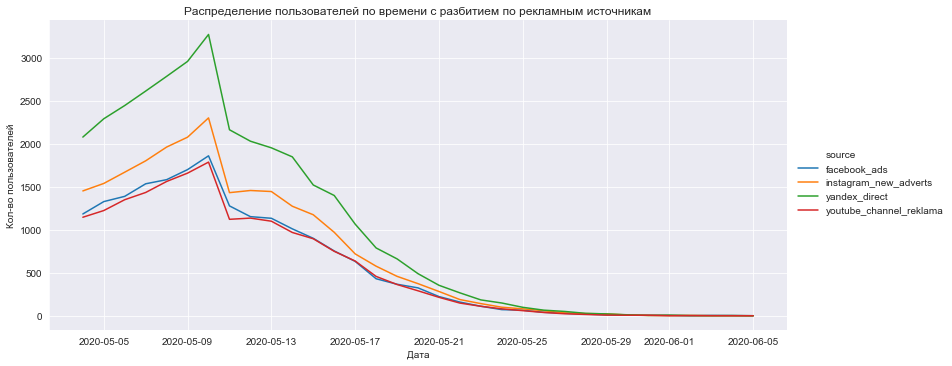

In [19]:
sns.relplot(data=dau_groupby, x='event_date', y='user_id', hue='source', kind='line', aspect=18/8)
plt.title('Распределение пользователей по времени с разбитием по рекламным источникам')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата');

In [20]:
print('Среднее кол-во пользователей в день:', dau.groupby('event_date')['user_id'].nunique().median())

Среднее кол-во пользователей в день: 1480.0


Реклама была дана первую неделю, поэтому в начале можно наблюдать рост пользователей с пиком в конце недели. Резкий спад новых пользователей обусловлен остановкой рекламы и прекращением их прибывания. Далее наблюдается низходящий тренд, обусловленный переходом пользователей на новый уровень либо прекращением активности.

### Retention Rate

Для расчета удержания, возьмем дату, когда пользователь впервые проявил активность, присоединим к исходной таблице `events` и сохраним в новый датафрейм `user_activity` 

In [21]:
first_activity_date = events.groupby(['user_id'])['event_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = events.join(first_activity_date,on='user_id')

Преобразуем столбец `first_activity_day` к формату datetime:

In [22]:
user_activity['first_activity_day'] = pd.to_datetime(user_activity['first_activity_date'])

Рассчитаем lifetime пользователя в рамках когорты:

In [23]:
user_activity['cohort_lifetime'] = ((user_activity['event_date'] - user_activity['first_activity_day']) / np.timedelta64(1,'W')).round().astype(int)

Cгруппируем данные по когорте и lifetime:

In [24]:
cohorts = user_activity.groupby(['first_activity_day', 'cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

Найдем исходное кол-во пользователей в когорте и переименуем в `cohort_users`:

In [25]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_day','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})

Объеденим данные по когортам с исходным кол-вом пользователей в когорте:

In [26]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_day')

Рассчитаем retention rate и построим сводную таблицу:

In [27]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_day',columns='cohort_lifetime',values='retention',aggfunc='sum')

Выведем тыпловую карту:

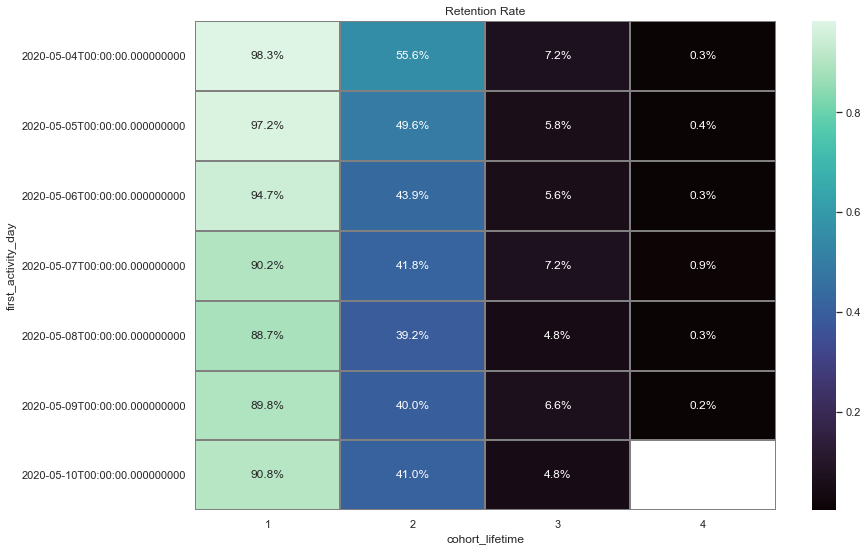

In [28]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot.drop(0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="mako");

Из тепловой карты видно, что удержание пользователей на 3ю неделю снизилось в 2 раза и к концу 5ой недели вовсе упало до 0%

## Маркетинг
[вернуться к содержанию](#content)

Посмотрим, сколько денег было потрачено на каждый рекламный источник:

In [29]:
ad_costs.groupby('source')['cost'].sum().sort_values(ascending=False).reset_index()

,source,cost
0,yandex_direct,2233.111449
1,instagram_new_adverts,2161.441691
2,facebook_ads,2140.904643
3,youtube_channel_reklama,1068.119204


Посмотрим, сколько пользователей привлек каждый рекламный источник:

,user_id
source,
yandex_direct,4817
instagram_new_adverts,3347
facebook_ads,2726
youtube_channel_reklama,2686


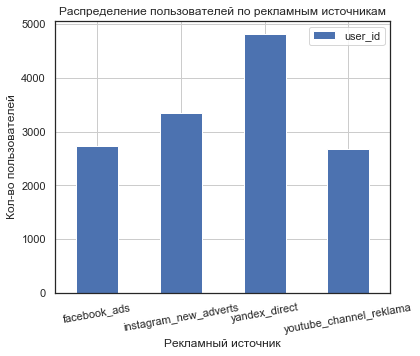

In [30]:
source_current = user_source.groupby('source').agg({'user_id':'nunique'})
display(source_current.sort_values(by='user_id', ascending=False))

source_current.plot(kind='bar', figsize=(6,5), grid=True)
plt.title('Распределение пользователей по рекламным источникам')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Рекламный источник')
plt.xticks(rotation=10);

Построим и визуализируем сводную таблицу с расходами по дням:

day,2020-05-03 00:00:00,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,2020-05-07 00:00:00,2020-05-08 00:00:00,2020-05-09 00:00:00,total
source,,,,,,,,
facebook_ads,935.882786,548.354480,260.185754,177.982200,111.766796,68.009276,38.723350,2140.904643
instagram_new_adverts,943.204717,502.925451,313.970984,173.071145,109.915254,71.578739,46.775400,2161.441691
yandex_direct,969.139394,554.651494,308.232990,180.917099,114.429338,62.961630,42.779505,2233.111449
youtube_channel_reklama,454.224943,259.073224,147.041741,88.506074,55.740645,40.217907,23.314669,1068.119204
total,3302.451840,1865.004649,1029.431469,620.476519,391.852033,242.767553,151.592924,7603.576987


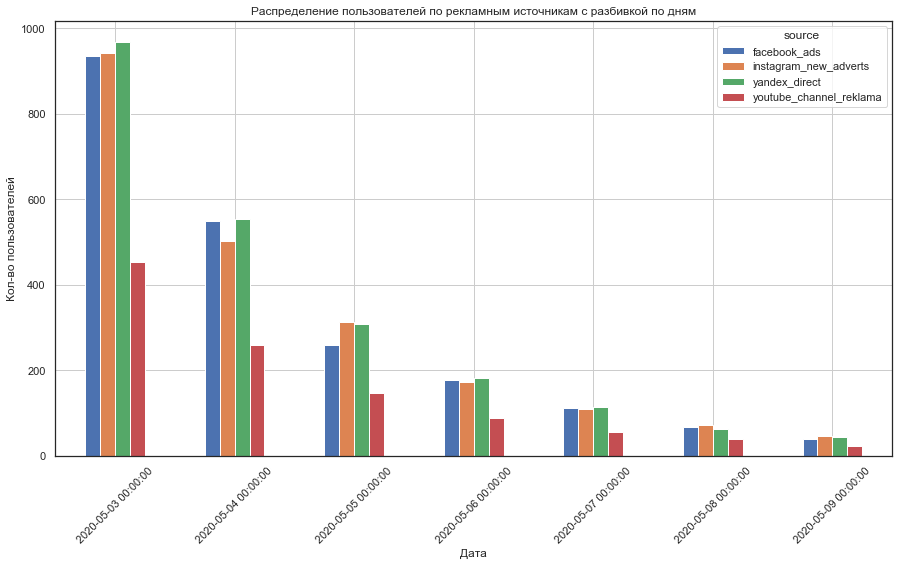

In [31]:
display(ad_costs.pivot_table(index='source', columns='day', values='cost', aggfunc='sum', margins=True, margins_name='total'))

ad_costs_pivot = ad_costs.pivot_table(index='source', columns='day', values='cost', aggfunc='sum')
ad_costs_pivot.T.plot(kind='bar', figsize=(15,8), grid=True)
plt.title('Распределение пользователей по рекламным источникам c разбивкой по дням')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата')
plt.xticks(rotation=45);

Из графика видно, что в первый день закупки рекламы было потрачено 3302 у.е. и далее, в течение недели, траты снизились до 151 у.е. 

#### Рассичтаем CAC (стоимость привлечения клиента):<a id="cac"></a>

In [32]:
cac = ((ad_costs.groupby('source')['cost'].sum()/user_source['user_id'].nunique())
 .sort_values(ascending=False)
 .reset_index()
 .rename({'cost':'cac'}, axis=1))

cac

,source,cac
0,yandex_direct,0.164490
1,instagram_new_adverts,0.159210
2,facebook_ads,0.157698
3,youtube_channel_reklama,0.078677


#### Выводы:
* Больше всего потратили на источник `yandex_direct (2233 у.е.)`, также этот источник имеет наибольший показатель CAC (0.16 у.e.)
* Меньше всего потратили на источник `youtube_channel_reklama (1068 у.е.)`, показатель CAC у него наименьший (0.08 у.е.)


## Анализ влияния событий на совершение целевого события<a id="target_analysis"></a>
[вернуться к содержанию](#content)

### Время, за которое пользователесь завершает уровень:

In [33]:
#первое событие для пользователя
first_user_event = events.groupby('user_id')['event_datetime'].min().reset_index().rename(columns={'event_datetime':'first_event'})
#последнее событие для пользователя
last_user_event = events.groupby('user_id')['event_datetime'].max().reset_index().rename(columns={'event_datetime':'last_event'})
#таблицы для слияния
events_for_users = events[['user_id', 'event_datetime', 'event']]
user_project_type = events[['user_id', 'project_type']].query('project_type != "none"')

In [34]:
#соединяем таблицы
users_first_last_event = (first_user_event
    .merge(last_user_event, how='left', on='user_id')
    .merge(events_for_users, how='left', left_on=['user_id', 'last_event'], right_on=['user_id', 'event_datetime'])
    .merge(user_project_type, how='left', on='user_id')
    .drop('event_datetime', axis=1))

#заполним пропуски
users_first_last_event['project_type'] = users_first_last_event['project_type'].fillna('none')
#выделим длительность между первым и последним действием
users_first_last_event['path_duration'] = users_first_last_event['last_event'] - users_first_last_event['first_event']
#переведем длительность в дни
users_first_last_event['path_days'] = users_first_last_event['path_duration'].dt.days
users_first_last_event.head()

,user_id,first_event,last_event,event,project_type,path_duration,path_days
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,building,none,14 days 10:18:29,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,building,none,12 days 07:37:40,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,building,none,8 days 15:12:35,8
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,finished_stage_1,none,6 days 10:38:42,6
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,building,none,16 days 12:56:47,16


#### Пользователи, реализовавшие проект:

Среднее время, за которое пользователь реализовывает проект: 13 дней
Кол-во пользователей: 1866


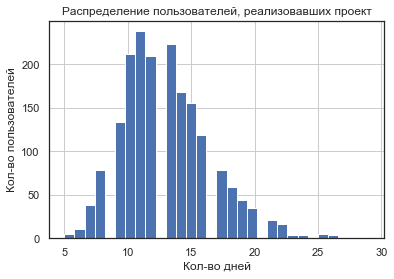

In [35]:
who_made_project = users_first_last_event.query('project_type != "none"')
print('Среднее время, за которое пользователь реализовывает проект:',round(who_made_project['path_days'].mean()), 'дней')
print('Кол-во пользователей:', len(who_made_project) )

who_made_project.hist(bins='auto')
plt.title('Распределение пользователей, реализовавших проект')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во дней');

#### Пользователи, победившие первого врага:

Среднее время, за которое пользователь совершает победу над другим игроком: 11 дней
Кол-во пользователей: 3951


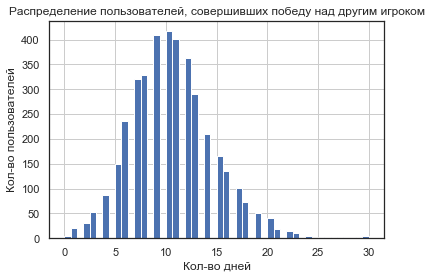

In [36]:
who_made_victory = users_first_last_event.query('project_type == "none" and event == "finished_stage_1"')
print('Среднее время, за которое пользователь совершает победу над другим игроком:',round(who_made_victory['path_days'].mean()), 'дней')
print('Кол-во пользователей:', len(who_made_victory) )

who_made_victory.hist(bins='auto')
plt.title('Распределение пользователей, совершивших победу над другим игроком')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во дней');

#### Пользователи, непрошедшие первый уровень:

Среднее время, за которое пользователь останавливается в прогрессе:  9 дней
Кол-во пользователей: 7759


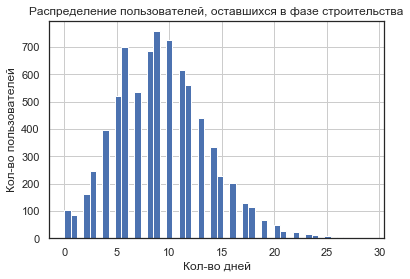

In [37]:
who_still_building = users_first_last_event.query('event == "building"')
print('Среднее время, за которое пользователь останавливается в прогрессе: ',round(who_still_building['path_days'].mean()), 'дней')
print('Кол-во пользователей:', len(who_still_building) )

who_still_building.hist(bins='auto')
plt.title('Распределение пользователей, оставшихся в фазе строительства')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во дней');

Сводная таблица:

In [38]:
wsb_pivot = (who_still_building
             .pivot_table(index='event', values=['user_id', 'path_days'], aggfunc={'user_id':'count', 'path_days':'mean'})
             .rename({'building':'who_still_building'}, axis=0)
             .reset_index())

wmv_pivot = (who_made_victory
             .pivot_table(index='event', values=['user_id', 'path_days'], aggfunc={'user_id':'count', 'path_days':'mean'})
             .rename({'finished_stage_1':'who_made_victory'}, axis=0)
             .reset_index())

wmp_pivot = (who_made_project
             .pivot_table(index='event', values=['user_id', 'path_days'], aggfunc={'user_id':'count', 'path_days':'mean'})
             .rename({'finished_stage_1':'who_made_project'}, axis=0)
             .reset_index())

who_concat = pd.concat([wsb_pivot, wmv_pivot, wmp_pivot]).reset_index(drop=True)
who_concat['path_days'] = round(who_concat['path_days'])
who_concat['%_of_total'] = (who_concat['user_id'] / who_concat['user_id'].sum()).round(2)

#### Выводы:

In [39]:
who_concat

,event,path_days,user_id,%_of_total
0,who_still_building,9.0,7759,0.57
1,who_made_victory,11.0,3951,0.29
2,who_made_project,13.0,1866,0.14


* Большинство пользователей (57%) остановились в прогрессе и не прошли первый уровень
* 29% пользователей прошли первый уровень победой над врагом
* 14% выбрали путь реализации проекта
* Только 43% пользователей прошли первый уровень

### Есть ли разница в проценте прохождения уровня в зависимости от источника трафика

Добавим к таблице `users_first_last_event` таблицу с рекламным источниками, с которых пришли пользователи:

In [40]:
users_first_last_event = users_first_last_event.merge(user_source, on='user_id', how='left')

Отфильтруем пользователей, прошедших первый уровень и сгруппируем по рекламному источнику:

In [41]:
finished_by_source = users_first_last_event.query('event == "finished_stage_1"').groupby('source')['event'].count().reset_index()

Соединим таблицы `finished_by_source` и `source_current`:

In [42]:
source_merge = (finished_by_source
    .merge(source_current.reset_index(), on='source', how='left')
    .rename(columns={'event':'finished_users', 'user_id':'attracted_users'}))

In [43]:
source_merge['%_of_finished'] = source_merge['finished_users'] / source_merge['attracted_users']
source_merge.merge(cac).sort_values(by='%_of_finished', ascending=False)

,source,finished_users,attracted_users,%_of_finished,cac
1,instagram_new_adverts,1466,3347,0.438004,0.159210
3,youtube_channel_reklama,1159,2686,0.431497,0.078677
2,yandex_direct,2042,4817,0.423915,0.164490
0,facebook_ads,1150,2726,0.421864,0.157698


Можно сказать, что разницы в проценте прохождения уровня в зависимости от источника трафика нет. `youtube_channel_reklama` привлек довольно много "дешевых" пользователей и можно назвать этот источник приоритетным и увеличить вложения в него.

## Проверка гипотез:<a id="stat_test"></a>
[вернуться к содержанию](#content)

#### Проверим гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

* `H0` = Различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком `нет`
* `H1` = Различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком `есть`

In [44]:
alpha = 0.05

results = st.ttest_ind(who_made_project['path_days'], who_made_victory['path_days'], equal_var = False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, различие между пользователями есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет")

p-значение:  2.6237027268062713e-106
Отвергаем нулевую гипотезу, различие между пользователями есть


In [45]:
who_concat.drop(0, axis=0).drop({'user_id', '%_of_total'}, axis=1)

,event,path_days
1,who_made_victory,11.0
2,who_made_project,13.0


Те, кто выбирают пройти первый уровень путем реализации проекта - проходят его дольше на 2 дня в сравнении с теми, кто прошел уровень победив первого врага.

___

#### Проверим гипотезу о различии времени прохождения уровня пользователями в зависимости от рекламного источника
Сравним источники с самым высоким процентом (`instagram_new_adverts (44%)`) и самым низким (`facebook_ads (42%)`) 

* `H0` = Различия времени прохождения уровня пользователями в зависимости от рекламного источника `нет`
* `H1` = Различие времени прохождения уровня пользователями в зависимости от рекламного источника `есть`

In [46]:
facebook = users_first_last_event[['source', 'path_days']].query('source == "facebook_ads"')
instagram = users_first_last_event[['source', 'path_days']].query('source == "instagram_new_adverts"')

In [47]:
alpha = 0.05

results = st.ttest_ind(facebook['path_days'], instagram['path_days'], equal_var = False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, различие между пользователями есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет")

p-значение:  0.5529958757362929
Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет


## Выводы и рекомендации:<a id="summary"></a>
[вернуться к содержанию](#content)

* Кол-во уникальных пользователей: 135639
* Среднее кол-во пользователей в день: 1480
* Среднее время, за которое пользователь реализовывает проект:  13 дней
* Среднее время, за которое пользователь совершает победу над другим игроком:  10 дней
* Среднее время, за которое пользователь останавливается в прогрессе:  9 дней
* Большинство пользователей (57%) остановились в прогрессе и не прошли первый уровень. Предположительно, пользователям может показаться медленным их прогресс и им может надоесть играть.
* 29% пользователей прошли первый уровень победой над врагом. Можно предположить, что сделать это легче и быстрее, чем реализовать проект
* 14% выбрали путь реализации проекта. Стоит облегчить условия для постройки, чтобы больше пользователей выбирают этот путь
* Только 43% пользователей прошли первый уровень
* Есть статистически значимое различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком 
* Статистически значимого различия времени прохождения уровня пользователями в зависимости от рекламного источника не выявлено

Отвечая на вопрос "какую модель монетизации стоит выбрать для игрового приложения?", можно рассмотреть варианты: 
* Ускорение строительства построек посредством просмотра рекламного баннера
* Разовые ускорители строительства построек за донат
* Покупка построек за донат
* Показ рекламного баннера в меню взаимодействия с постройкой

Чтобы окупить затраты на рекламу, цену за показ рекламного баннера рекомендуется ставить не ниже, чем в [данном CAC](#cac)

Также рекомендуется увеличить вложения в рекламный источник `youtube_channel_reklama`, т.к. он приносит много "дешевыхЭ пользователей.
___

#### Ссылка на презентацию:
https://docs.google.com/presentation/d/1Lt5LWm6jinXnewFzhChulfGNggDJo2XCmYLtJFxwxbs/edit?usp=sharing

#### Ссылка на дашборд:
https://public.tableau.com/profile/nikita8358#!/vizhome/SpaceBrothers/Dashboard3?publish=yes